In [24]:
# Install required packages
!pip install kaggle kagglehub librosa pandas matplotlib seaborn scikit-learn tensorflow

# Upload kaggle.json (from your Kaggle account)
from google.colab import files
files.upload()  # Select your kaggle.json file

# Move kaggle.json to the correct location and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download GTZAN dataset from Kaggle
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

# Unzip the dataset
!unzip gtzan-dataset-music-genre-classification.zip -d gtzan_dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gtzan-dataset-music-genre-classification.zip
replace gtzan_dataset/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gtzan_dataset/Data/features_30_sec.csv  
  inflating: gtzan_dataset/Data/features_3_sec.csv  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00000.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00001.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00002.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00003.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00004.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00005.wav  
  inflating: gtzan_dataset/Data/genre

In [16]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [17]:
# 7. Feature extraction function
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [18]:
# 8. Load dataset and extract features
dataset_dir = "gtzan/Data/genres_original"
genres = os.listdir(dataset_dir)
features_list = []
labels_list = []

for genre in genres:
    genre_dir = os.path.join(dataset_dir, genre)
    for file_name in os.listdir(genre_dir):
        file_path = os.path.join(genre_dir, file_name)
        features = extract_features(file_path)
        if features is not None:
            features_list.append(features)
            labels_list.append(genre)

# Convert to DataFrame
features_df = pd.DataFrame(features_list)
features_df['label'] = labels_list

/tmp/ipython-input-788280049.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing gtzan/Data/genres_original/jazz/jazz.00054.wav: 


In [19]:
# 9. Prepare data for ML
X = features_df.iloc[:, :-1].values
y = LabelEncoder().fit_transform(features_df['label'])

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# 10. Build a simple neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# 11. Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1770 - loss: 2.2578 - val_accuracy: 0.4000 - val_loss: 1.8551
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4013 - loss: 1.7956 - val_accuracy: 0.4350 - val_loss: 1.6515
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5343 - loss: 1.4818 - val_accuracy: 0.5100 - val_loss: 1.5082
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5192 - loss: 1.3924 - val_accuracy: 0.5100 - val_loss: 1.4047
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5547 - loss: 1.2826 - val_accuracy: 0.5300 - val_loss: 1.3402
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6089 - loss: 1.0961 - val_accuracy: 0.5400 - val_loss: 1.3114
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6419 - loss: 1.0782 - val_accuracy: 0.5900 - val_loss: 1.2732
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6715 - loss: 0.9695 - val_accuracy: 0.5750 - val_loss

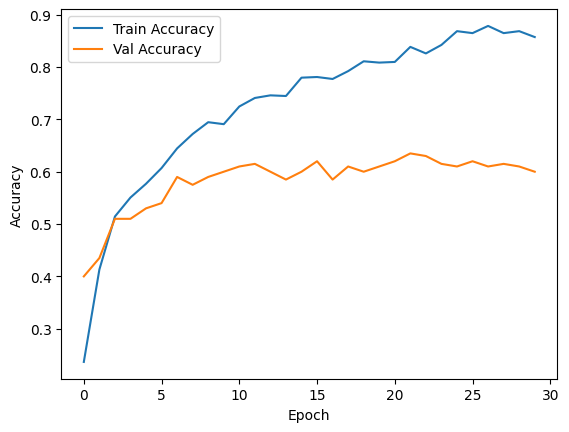

In [22]:
# 12. Plot training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# 13. Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5966 - loss: 1.4012 
Test Accuracy: 60.00%
